# Proyecto: Modelos No Lineales para Pronósticos MPST

## 1. Configuración inicial

En esta sección cargamos las librerías y ajustamos el entorno para el análisis, la visualización y el modelado de series de tiempo.



In [3]:
# 1. Configuración inicial: imports y entorno

import os
import datetime
import warnings
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import (
    Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten,
    Dropout, BatchNormalization, TimeDistributed, ConvLSTM2D, Reshape
)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import optuna
import joblib

# Ajustes de visualización
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings("ignore")

# Semilla para reproducibilidad
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Gestión de memoria y GPU
gc.enable()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0], 'GPU')


### 2. Carga y limpieza de datos (PJM)

Cargamos los precios horarios de PJM desde el CSV, parseamos la columna Date como índice y ordenamos cronológicamente. Luego renombramos las columnas para eliminar espacios y corregir un tipo (foecast → forecast). Finalmente separamos:

- *y*: precio zonal (zonal_comed_price)  
- *X*: pronósticos de carga (system_load_forecast, zonal_comed_load_forecast)

In [10]:
# Ruta y archivo
data_dir = "Zenodo-electricity-MPST/"
csv_path = os.path.join(data_dir, "PJM.csv")

In [11]:
# Carga con parseo de fecha (“Date”) como índice y ordenamiento
df_raw = (
    pd.read_csv(csv_path, parse_dates=["Date"], index_col="Date")
      .sort_index()
)

In [14]:
df_raw

,zonal_comed_price,system_load_forecast,zonal_comed_load_forecast
Date,,,
2013-01-01 00:00:00,25.464211,85049.0,11509.0
2013-01-01 01:00:00,23.554578,82128.0,10942.0
2013-01-01 02:00:00,22.122277,80729.0,10639.0
2013-01-01 03:00:00,21.592066,80248.0,10476.0
2013-01-01 04:00:00,21.546501,80850.0,10445.0
...,...,...,...
2018-12-24 19:00:00,29.761473,94939.0,11246.0
2018-12-24 20:00:00,27.897676,94035.0,11070.0
2018-12-24 21:00:00,26.405903,92923.0,10963.0


In [12]:
# Renombrar columnas: quitar espacios, corregir typo y usar minúsculas con guiones bajos
rename_map = {
    " Zonal COMED price":            "zonal_comed_price",
    " System load forecast":         "system_load_forecast",
    " Zonal COMED load foecast":     "zonal_comed_load_forecast",
}
df_raw.rename(columns=rename_map, inplace=True)

In [13]:
y = df_raw["zonal_comed_price"]
X = df_raw[["system_load_forecast", "zonal_comed_load_forecast"]]

### 3. Limpieza de columnas y definición de variables

Copiamos df_raw, renombramos las columnas para quitar espacios y corregir el typo en “foecast”. Luego separamos:

- *y*: precio (price)  
- *X*: pronósticos de carga (system_load_forecast, zonal_load_forecast)

In [30]:
# Hacer copia de seguridad
df = df_raw.copy()

In [31]:
# Renombrar columnas: quitar espacios y corregir typo
df.rename(columns={
    "zonal_comed_price":            "price",
    "system_load_forecast":         "system_load_forecast",
    "zonal_comed_load_forecast":     "zonal_load_forecast",
}, inplace=True)

In [32]:
# Definir target y features
y = df["price"]
X = df[["system_load_forecast", "zonal_load_forecast"]]

In [33]:
# Liberar df_raw si ya no se usará
del df_raw
gc.collect()

4116

### 4. EDA: Series Temporales (Mercado PJM)

Mostramos:

1. *Todas las variables* en subplots independientes.  
2. *Precio zonal* (variable objetivo) en detalle.

*Observaciones clave*:
- Tendencia a largo plazo: crecimiento, decrecimiento o estabilidad.  
- Estacionalidad: patrones anuales, semanales o diarios.  
- Volatilidad: cambios en la amplitud de las oscilaciones.  
- Outliers o picos extremos.  
- Correlación visual entre precio y pronósticos de carga.

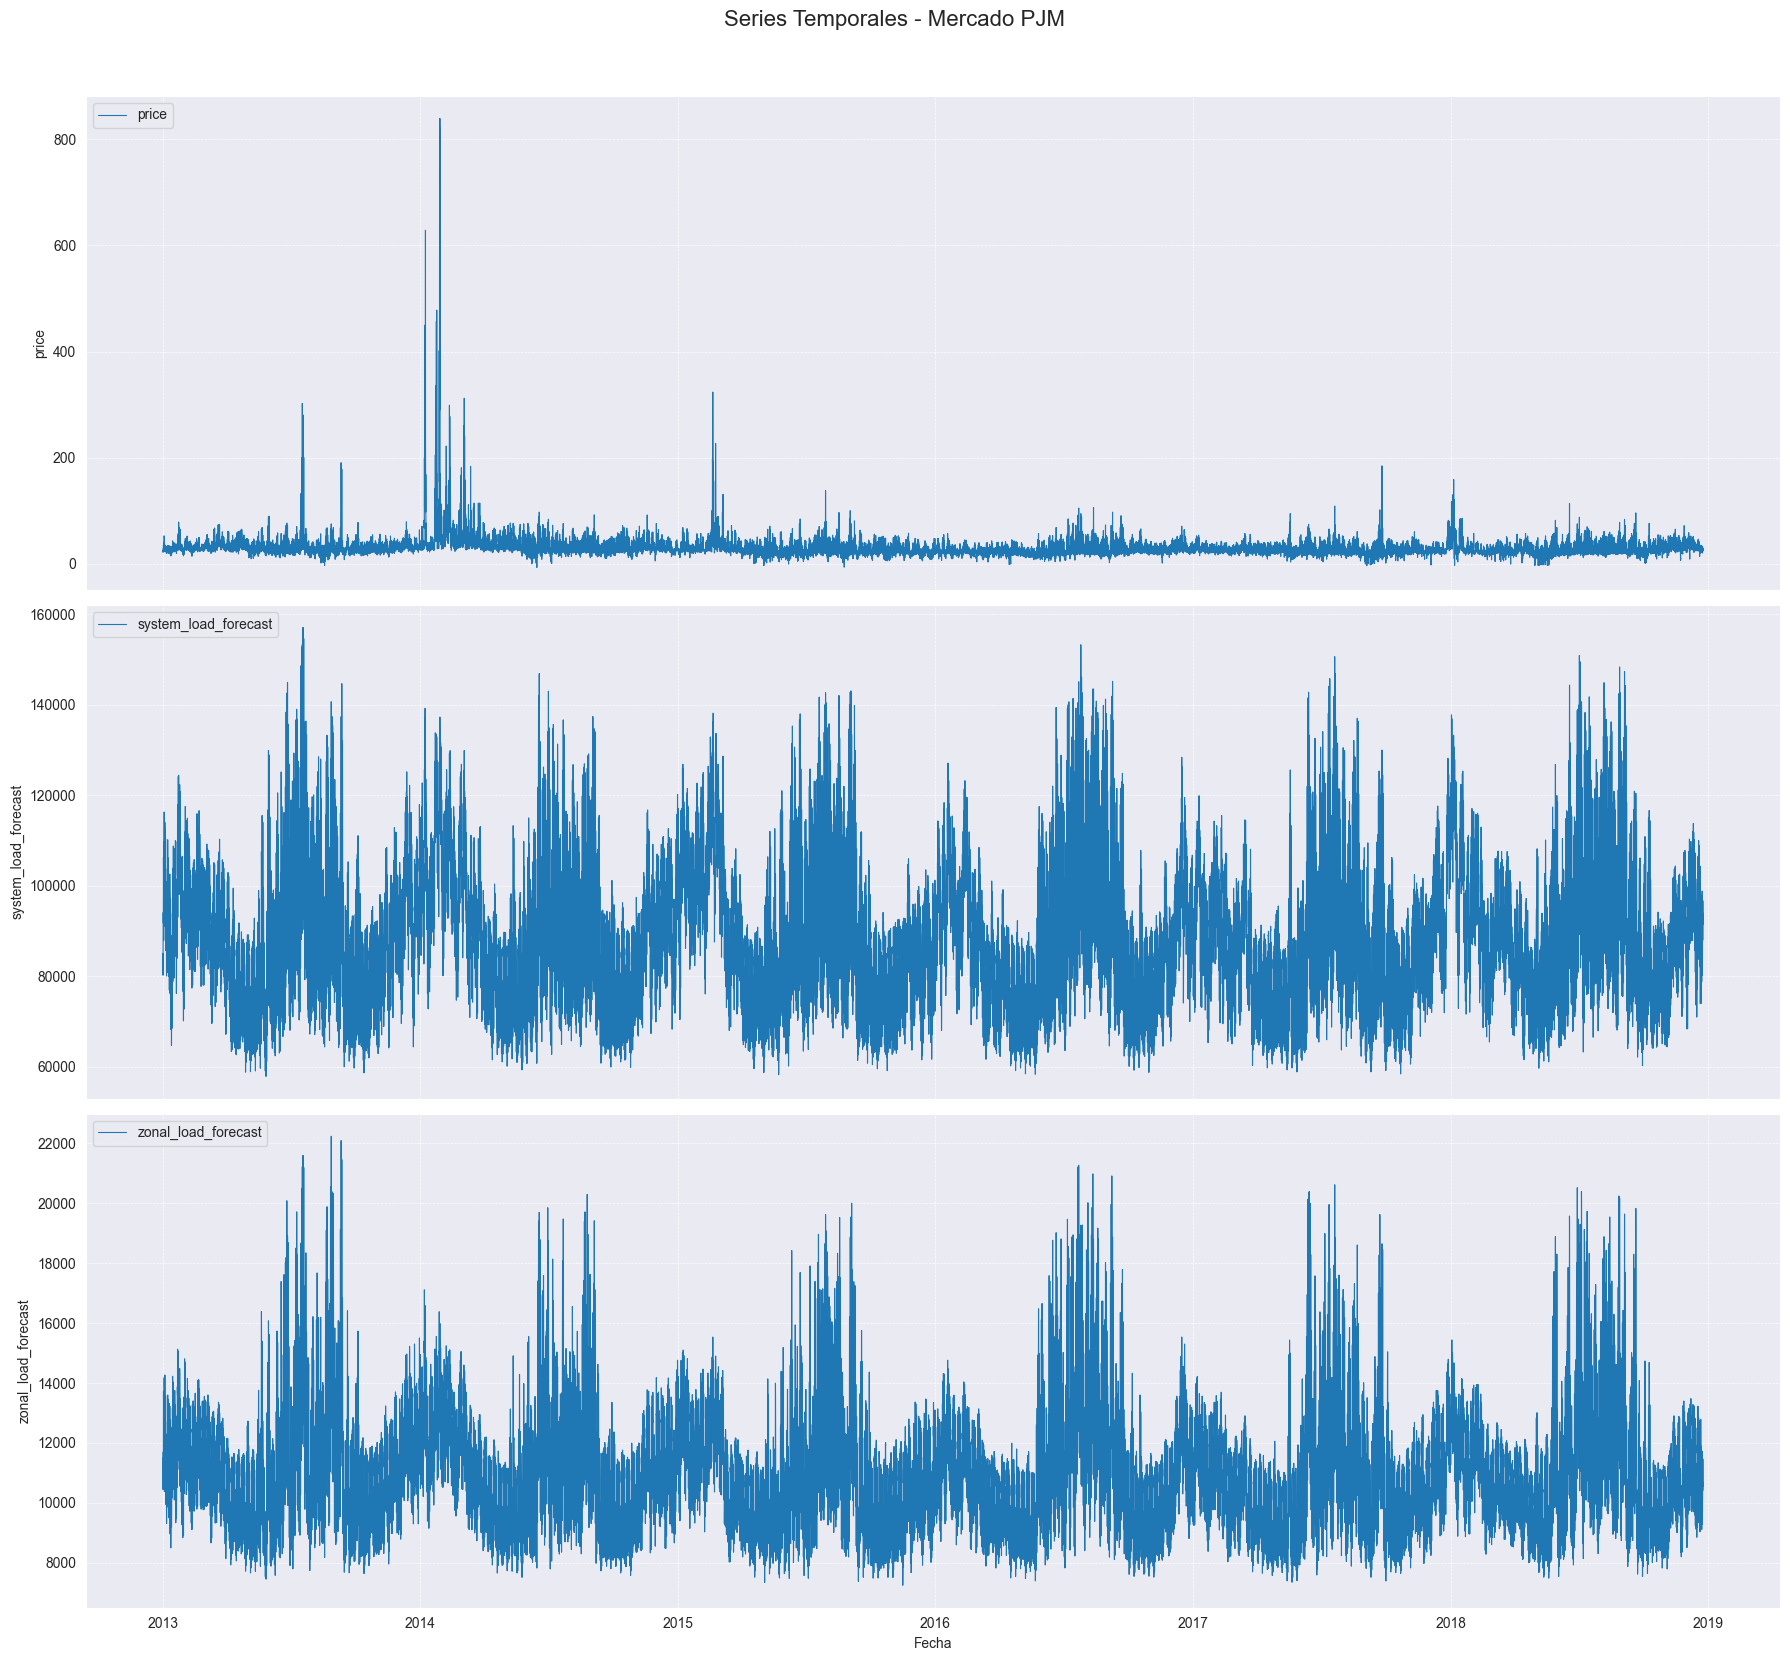

In [35]:
fig, axes = plt.subplots(
    nrows=df.shape[1], ncols=1,
    figsize=(18, 6 * df.shape[1]),
    sharex=True
)
fig.suptitle('Series Temporales - Mercado PJM', fontsize=16, y=0.92)

for ax, col in zip(axes, df.columns):
    ax.plot(df.index, df[col], label=col, linewidth=0.8)
    ax.set_ylabel(col)
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5)

axes[-1].set_xlabel('Fecha')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

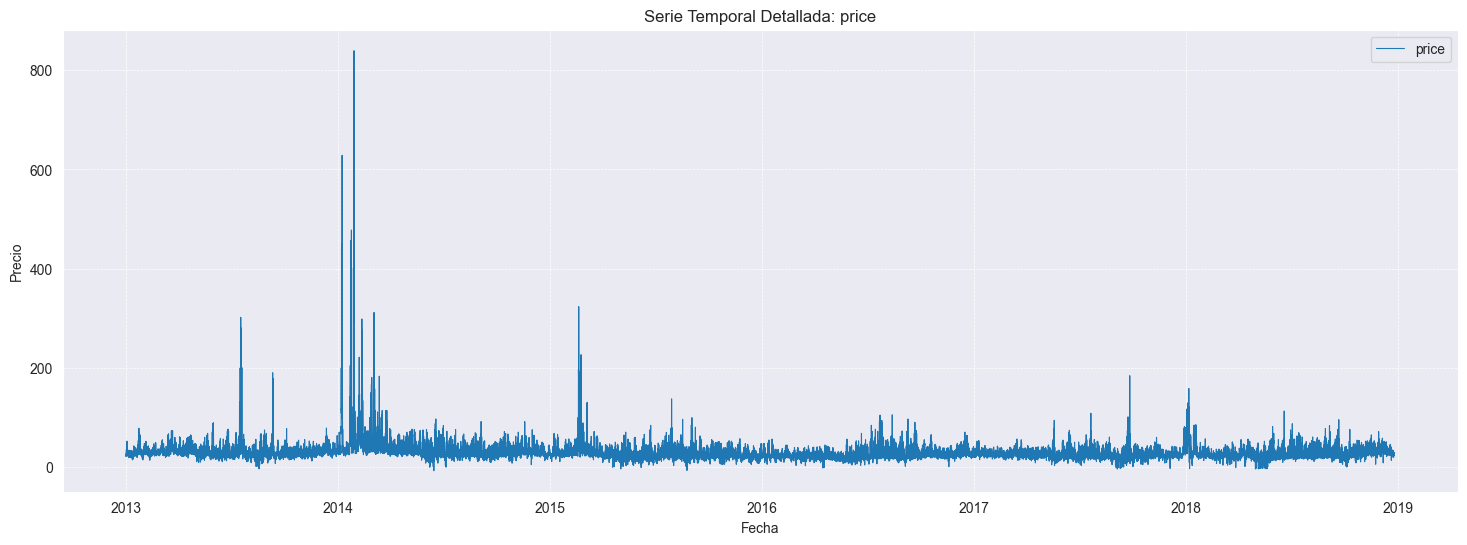

In [53]:
target_variable = "price"
feature_variables = X.columns
plt.figure(figsize=(18, 6))
plt.plot(df.index, df[target_variable], label=target_variable, linewidth=0.8)
plt.title(f'Serie Temporal Detallada: {target_variable}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 5. EDA: Descomposición STL

Aplicamos STL para dos escalas de estacionalidad:

- *Diaria* (periodo = 24)  
- *Semanal* (periodo = 168)  

Cada gráfico muestra:
1. *Trend* – la tendencia subyacente.  
2. *Seasonal* – el patrón estacional.  
3. *Residual* – el ruido restante.

Comparar ambas estacionalidades ayuda a identificar patrones en distintas escalas de tiempo.

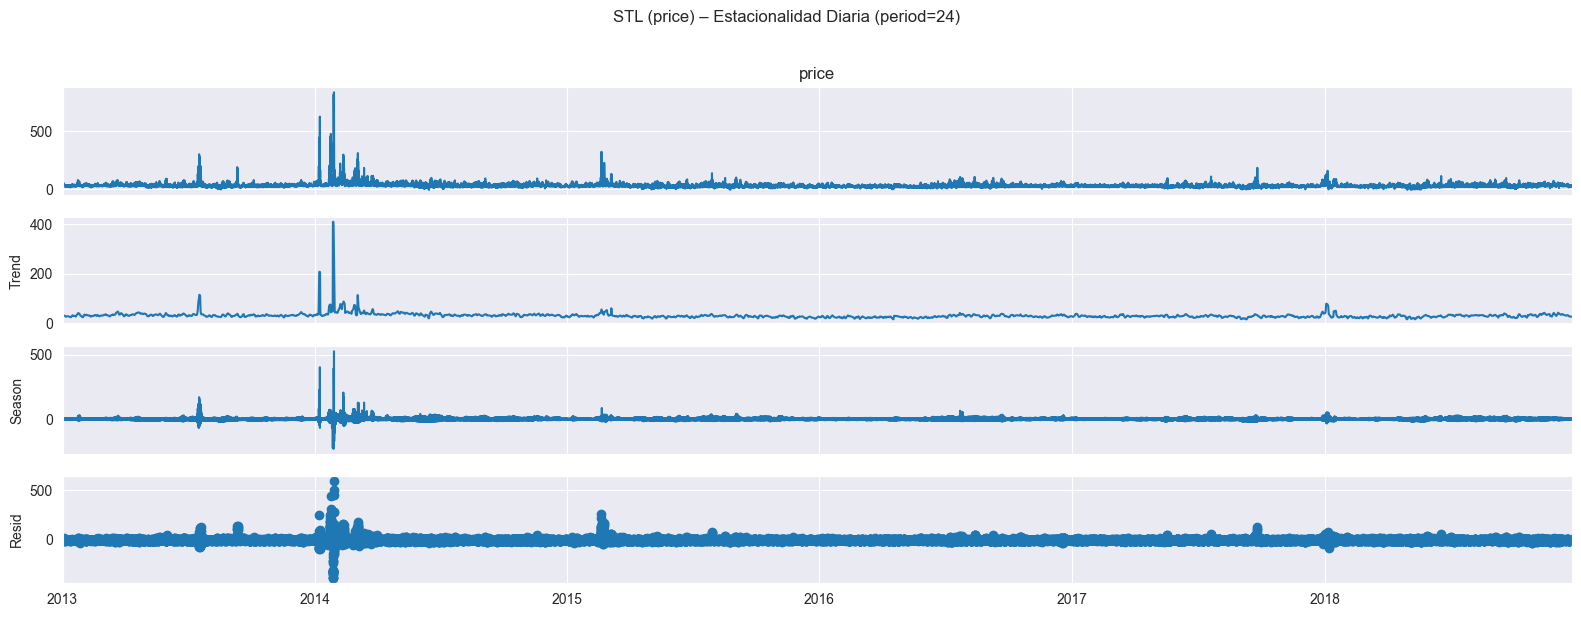

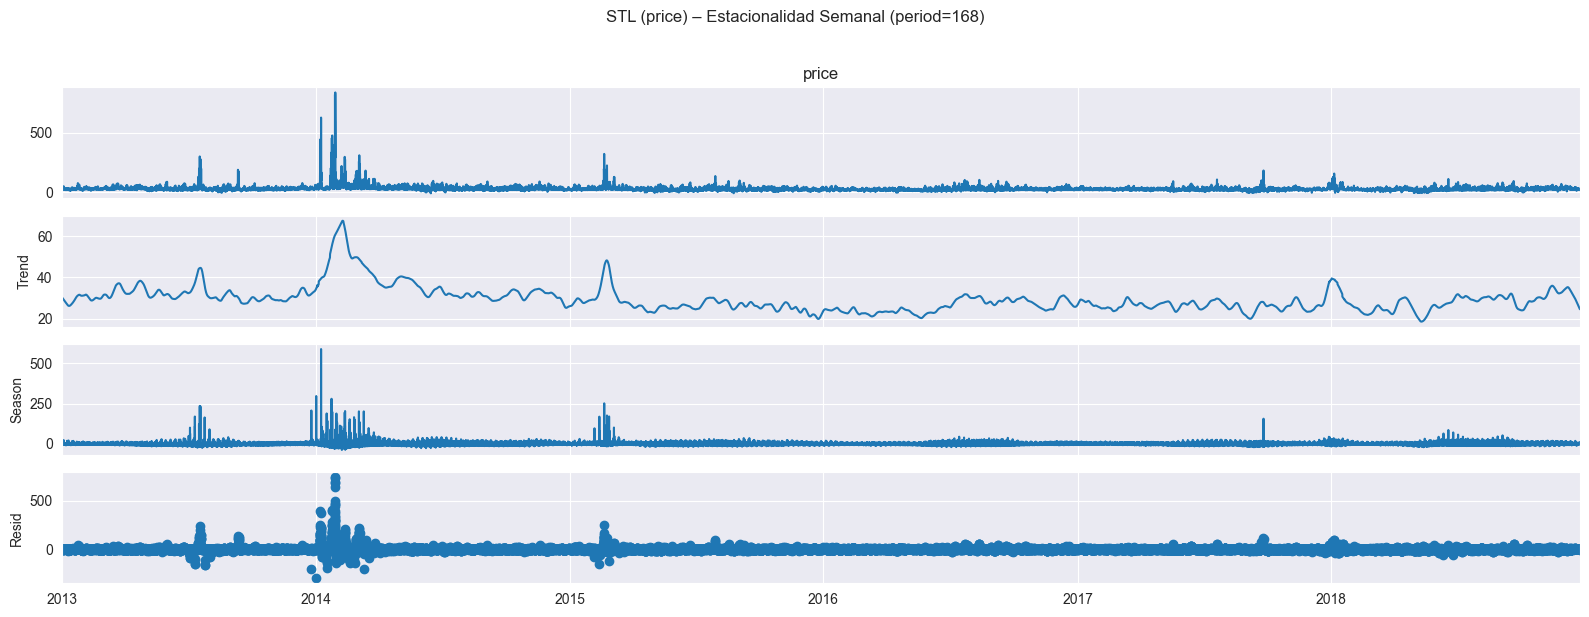

In [38]:
for period, label in [(24, "Diaria"), (24*7, "Semanal")]:
    stl_result = STL(df[target_variable].dropna(), period=period, robust=True).fit()
    fig = stl_result.plot()
    fig.suptitle(
        f"STL ({target_variable}) – Estacionalidad {label} (period={period})",
        y=1.02
    )
    plt.tight_layout()
    plt.show()

### 6. EDA: Estacionariedad y Autocorrelación

- *ADF Test*  
  - Estadístico ADF: adf_results["ADF Statistic"]  
  - p-value: adf_results["p-value"]  
  - Valores críticos:  
    - 1%: adf_results["crit_1%"]  
    - 5%: adf_results["crit_5%"]  
    - 10%: adf_results["crit_10%"]  
  > Si *p-value < 0.05*, rechazamos H₀ y la serie se considera estacionaria.

- *ACF y PACF* (lags = 168)  
  - *ACF*: observa la velocidad de decaimiento y picos en lags clave (e.g., 24, 168).  
  - *PACF*: identifica hasta qué rezago persiste la correlación (útil para órdenes AR).

In [39]:
# 6.1 Prueba de Dickey-Fuller Aumentada (ADF)
series = df[target_variable].dropna()
adf_stat, p_value, _, _, crit_vals, _ = adfuller(series)
adf_results = {
    "ADF Statistic": adf_stat,
    "p-value": p_value,
    **{f"crit_{level}": val for level, val in crit_vals.items()}
}

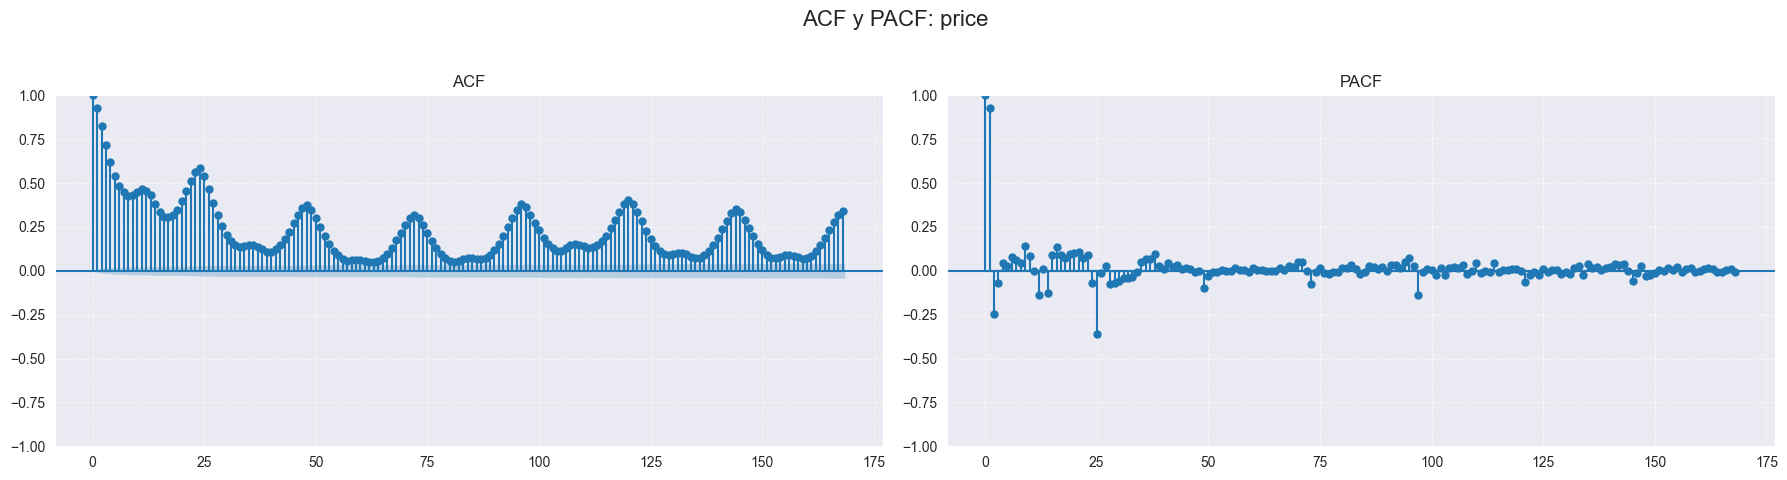

In [40]:
# 6.2 Gráficos de ACF y PACF (hasta 7 días de lags)
n_lags = 168
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle(f'ACF y PACF: {target_variable}', fontsize=16)

plot_acf(series, lags=n_lags, ax=axes[0])
axes[0].set_title('ACF')
axes[0].grid(True, linestyle='--', alpha=0.6)

plot_pacf(series, lags=n_lags, ax=axes[1], method='ols')
axes[1].set_title('PACF')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 7. Diferenciación Estacional y Evaluación de Estacionariedad

1. *Diferenciación estacional*: aplicamos S=24 (horas) para remover patrones diarios.  
2. *ADF Test* sobre la serie diferenciada (seasonal_diff), resultados en adf_seasonal_results.  
   - Si *p-value < 0.05*, rechazamos H₀ y la serie se considera estacionaria.  
3. *ACF/PACF* (lags=168) para identificar rezagos relevantes y posibles órdenes AR/SAR o MA/SMA.  
4. *Visualización* de la serie diferenciada para comprobar estabilidad (media cercana a 0 y varianza constante).

In [41]:
# 7.1 Diferenciación estacional (S = 24 horas)
S = 24
df['price_seasonal_diff'] = df[target_variable].diff(S)
seasonal_diff = df['price_seasonal_diff'].dropna()

In [42]:
# 7.2 ADF Test en la serie diferenciada
adf_stat_s, pval_s, _, _, crit_s, _ = adfuller(seasonal_diff)
adf_seasonal_results = {
    "ADF Statistic": adf_stat_s,
    "p-value": pval_s,
    **{f"crit_{level}": val for level, val in crit_s.items()}
}

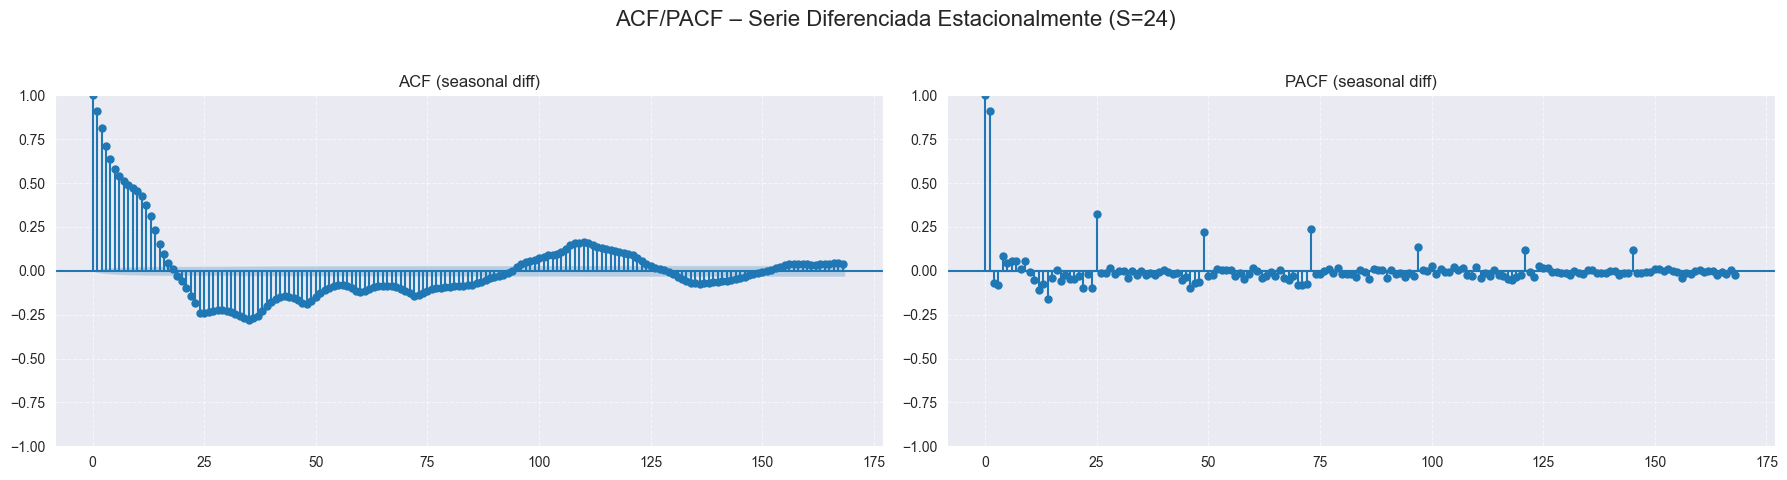

In [43]:
# 7.3 ACF y PACF (lags = 168)
n_lags = 168
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle(f'ACF/PACF – Serie Diferenciada Estacionalmente (S={S})', fontsize=16)

plot_acf(seasonal_diff, lags=n_lags, ax=axes[0])
axes[0].set_title('ACF (seasonal diff)')
plot_pacf(seasonal_diff, lags=n_lags, ax=axes[1], method='ols')
axes[1].set_title('PACF (seasonal diff)')

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

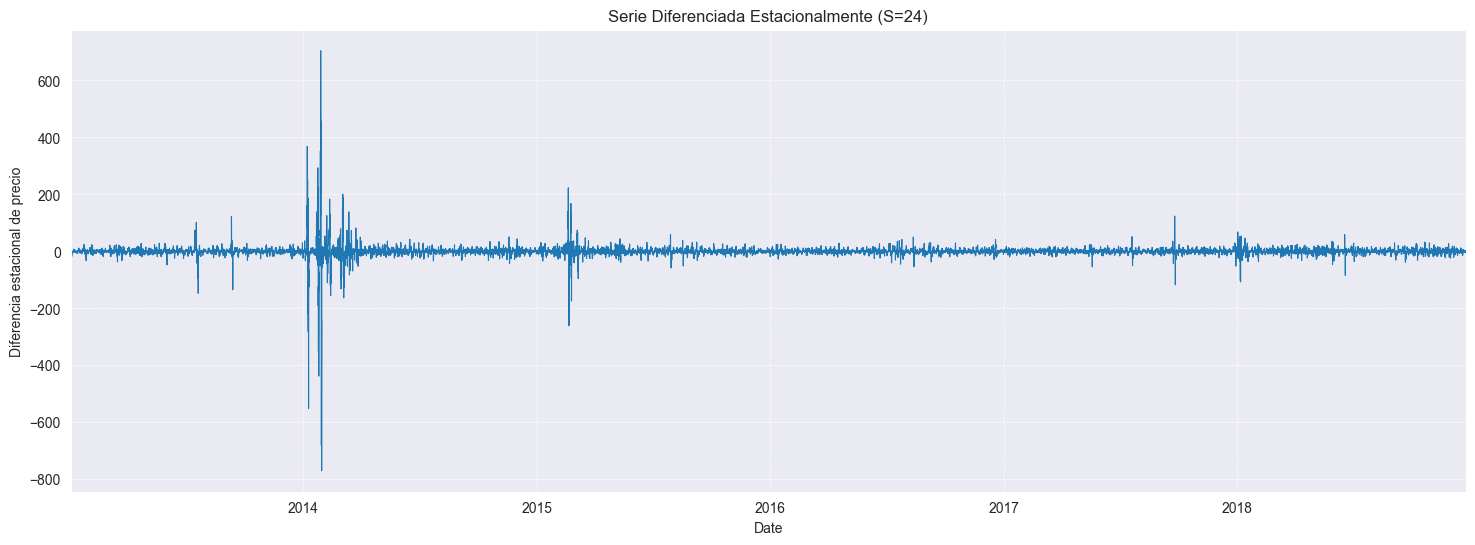

In [44]:
# 7.4 Serie diferenciada
plt.figure(figsize=(18, 6))
seasonal_diff.plot(title=f'Serie Diferenciada Estacionalmente (S={S})', linewidth=0.8)
plt.ylabel('Diferencia estacional de precio')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 8. División de datos (Train/Test)

Separamos los últimos *14 días* (336 horas) como conjunto de prueba y el resto como entrenamiento.  
Luego visualizamos la variable objetivo en ambos conjuntos para verificar la división cronológica.  
Finalmente, preparamos:
- *X_train, y_train*  
- *X_test,  y_test*

In [46]:
# Definir número de horas de prueba
n_test_hours = 14 * 24

# División cronológica
train_df = df.iloc[:-n_test_hours]
test_df  = df.iloc[-n_test_hours:]

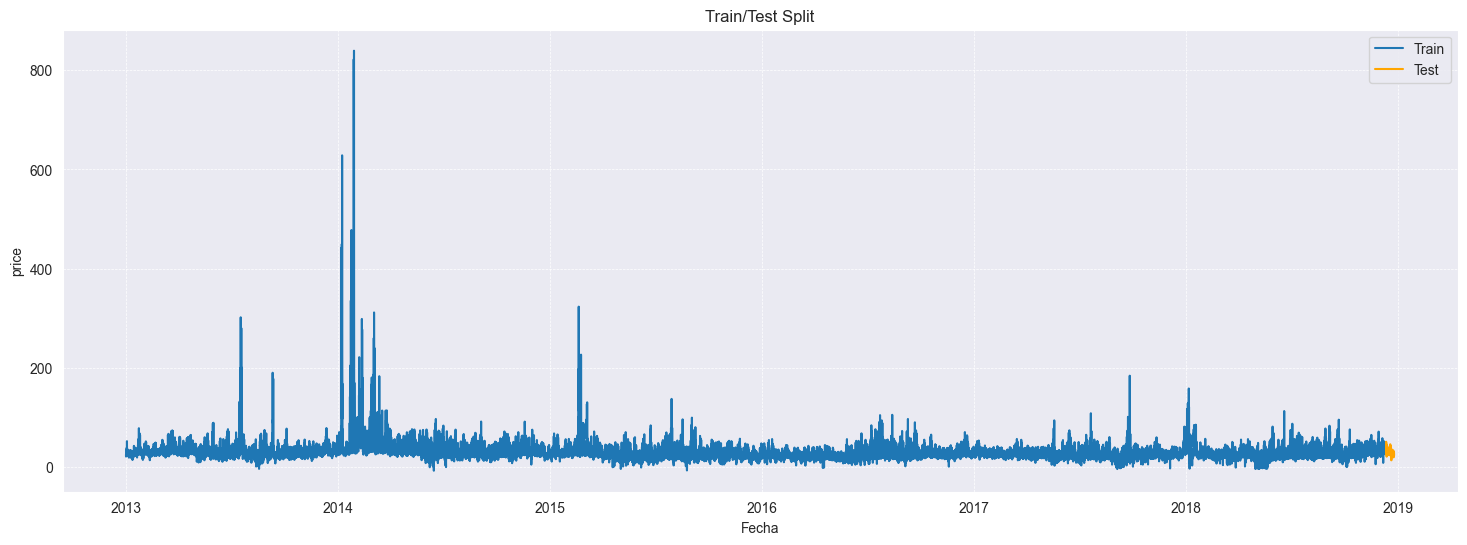

In [47]:
# Visualizar división en la serie objetivo
plt.figure(figsize=(18, 6))
plt.plot(train_df.index, train_df[target_variable], label='Train')
plt.plot(test_df.index,  test_df[target_variable],  label='Test', color='orange')
plt.title('Train/Test Split')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [54]:
X_train = train_df[feature_variables]
y_train = train_df[target_variable]
X_test  = test_df[feature_variables]
y_test  = test_df[target_variable]

### 9. SARIMA Univariado

Ajustamos un modelo SARIMA usando:
- *order* = (2, 0, 0)  
- *seasonal_order* = (1, 1, 1, 24)  

A continuación:
1. *Resumen* del modelo: coeficientes, AIC, pruebas estadísticas.  
2. *Diagnóstico de residuales*:  
   - Ruido blanco vs. patrones.  
   - Normalidad (Q-Q plot, Jarque-Bera).  
   - Autocorrelación (Ljung-Box).

In [55]:
# Parámetros del modelo (p, d, q) x (P, D, Q, S)
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 24)

# Ajuste del modelo
model = SARIMAX(
    endog=y_train,
    order=order,
    seasonal_order=seasonal_order,
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_sarima = model.fit(disp=False)

                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                52080
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 24)   Log Likelihood             -167408.699
Date:                              Wed, 14 May 2025   AIC                         334829.398
Time:                                      16:58:17   BIC                         334882.555
Sample:                                  01-01-2013   HQIC                        334846.018
                                       - 12-10-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.002      0.065      0.948      -0.004       0.005
ar.L1          1.01

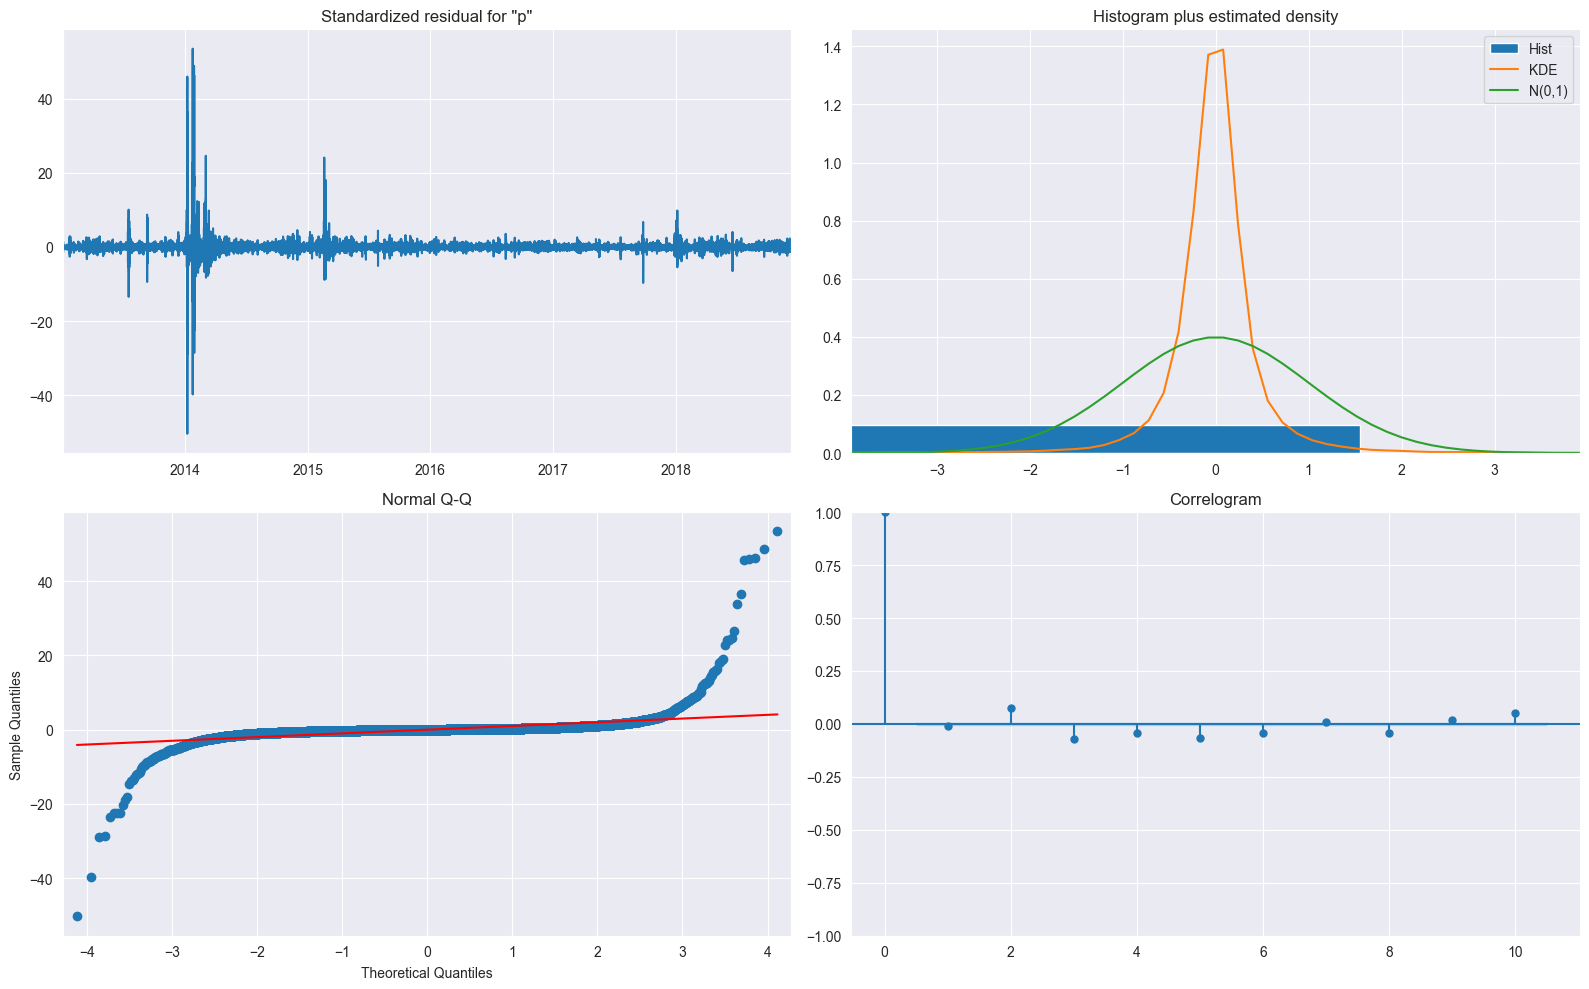

In [57]:
print(results_sarima.summary())
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

### 10. Pronósticos SARIMA

- Creamos el forecast a partir del modelo ajustado para los mismos pasos que el conjunto de prueba.  
- Obtenemos la media del pronóstico (y_pred_sarima) y los intervalos de confianza al 95% (lower_ci, upper_ci).  
- Visualizamos:
  - *Train (contexto)*: últimas 2×n_steps del set de entrenamiento.  
  - *Actual*: valores reales del test.  
  - *Forecast*: predicción SARIMA (línea discontinua).  
  - *95% CI*: sombreado de intervalo de confianza.

In [58]:
# Generar forecast
n_steps = len(y_test)
forecast_obj = results_sarima.get_forecast(steps=n_steps)
y_pred_sarima = forecast_obj.predicted_mean
conf_int        = forecast_obj.conf_int(alpha=0.05)
lower_ci, upper_ci = conf_int.iloc[:, 0], conf_int.iloc[:, 1]

# Alinear índices
y_pred_sarima.index = y_test.index
lower_ci.index      = y_test.index
upper_ci.index      = y_test.index

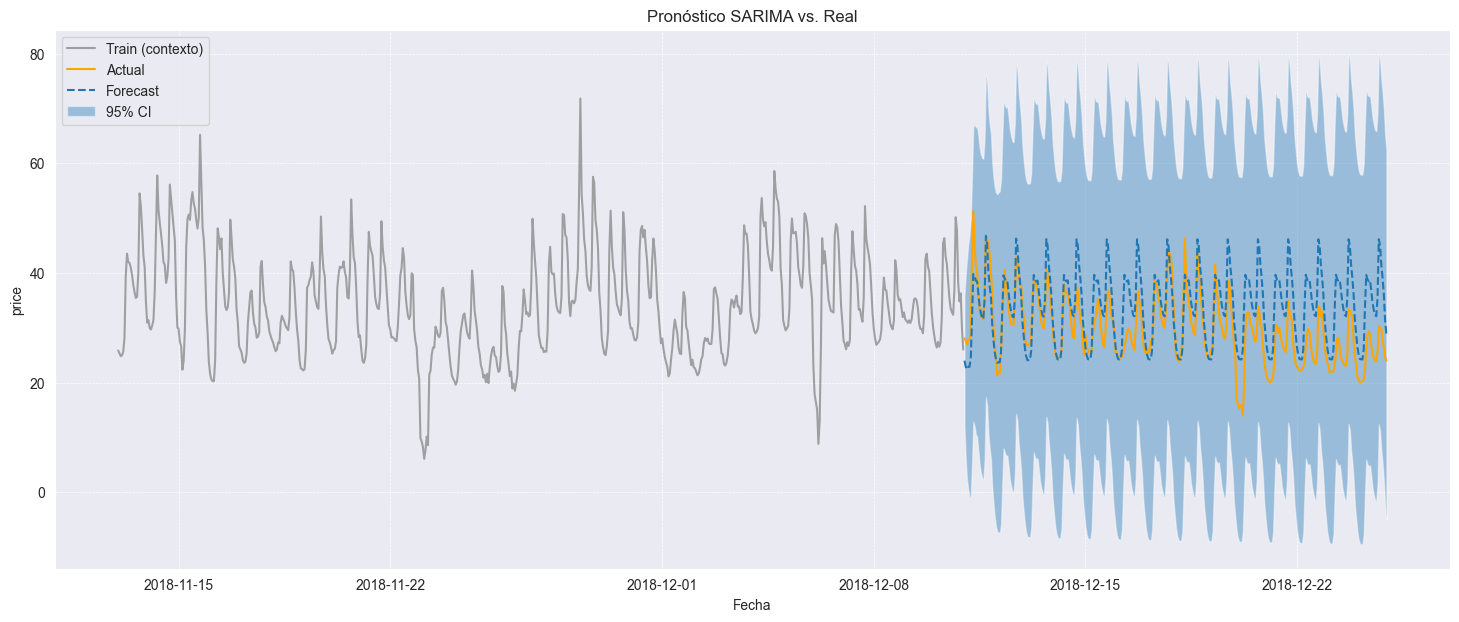

In [59]:
# Visualizar pronóstico vs. real
plt.figure(figsize=(18, 7))
plt.plot(
    train_df.index[-2*n_steps:], 
    y_train[-2*n_steps:], 
    label='Train (contexto)', 
    color='gray', alpha=0.7
)
plt.plot(y_test.index, y_test, label='Actual', color='orange', linewidth=1.5)
plt.plot(
    y_pred_sarima.index, 
    y_pred_sarima, 
    label='Forecast', 
    linestyle='--', linewidth=1.5
)
plt.fill_between(
    lower_ci.index, lower_ci, upper_ci,
    alpha=0.4, label='95% CI'
)
plt.title('Pronóstico SARIMA vs. Real')
plt.xlabel('Fecha')
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### 11. Evaluación del Modelo SARIMA (Baseline)

Calculamos las métricas de evaluación para el modelo SARIMA sobre el conjunto de prueba:

- *MAE*: Mean Absolute Error  
- *MSE*: Mean Squared Error  
- *RMSE*: Root Mean Squared Error  
- *MAPE (%)*: Mean Absolute Percentage Error  
- *R²*: Coeficiente de determinación  

Estas métricas servirán como baseline para comparar futuros modelos.

In [60]:
# 11.1 Calcular métricas
mae  = mean_absolute_error(y_test, y_pred_sarima)
mse  = mean_squared_error(y_test, y_pred_sarima)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_sarima)

In [61]:
# MAPE evitando ceros en y_test
mask = y_test != 0
mape = (np.abs((y_test[mask] - y_pred_sarima[mask]) / y_test[mask]).mean() * 100) if mask.any() else np.nan

In [62]:
# 11.2 Guardar y mostrar métricas
sarima_metrics = {
    'Model': 'SARIMA_Univariate',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE (%)': mape,
    'R2': r2
}

In [64]:
for metric, value in sarima_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

Model: SARIMA_Univariate
MAE: 4.8986
MSE: 37.2472
RMSE: 6.1031
MAPE (%): 17.5655
R2: 0.0154


### 12. Preparación de datos para redes neuronales

1. Definimos create_sequences para generar ventanas de tamaño 24 y horizonte 1.  
2. Escalamos datos con MinMaxScaler:
   - *Univariado*: solo la serie de precios.  
   - *Multivariado*: precio más variables exógenas.  
3. Creamos secuencias y aplanamos (reshape) la entrada para MLP.  
4. Guardamos los scaler para revertir la normalización tras el pronóstico.

In [65]:
def create_sequences(data, target, window_size, target_steps=1):
    X, y = [], []
    n = len(data)
    for i in range(n - window_size - target_steps + 1):
        X.append(data[i : i + window_size])
        y.append(target[i + window_size : i + window_size + target_steps])
    X = np.array(X)
    y = np.array(y)
    if target_steps == 1:
        y = y.reshape(-1, 1)
    return X, y

In [66]:
window_size = 24
target_steps = 1

In [67]:
# Univariado: precios
scaler_uni = MinMaxScaler()
train_uni = y_train.values.reshape(-1, 1)
test_uni  = y_test.values.reshape(-1, 1)
scaled_uni_train = scaler_uni.fit_transform(train_uni)
scaled_uni_test  = scaler_uni.transform(test_uni)

X_uni_train, y_uni_train = create_sequences(
    scaled_uni_train.flatten().reshape(-1,1),
    scaled_uni_train.flatten(),
    window_size, target_steps
)
X_uni_test, y_uni_test = create_sequences(
    scaled_uni_test.flatten().reshape(-1,1),
    scaled_uni_test.flatten(),
    window_size, target_steps
)

In [68]:
# Aplanar para MLP
X_uni_train_flat = X_uni_train.reshape(len(X_uni_train), -1)
X_uni_test_flat  = X_uni_test.reshape(len(X_uni_test),   -1)

In [69]:
# Multivariado: precio + exógenas
scaler_multi = MinMaxScaler()
train_multi = train_df.values
test_multi  = test_df.values
scaled_multi_train = scaler_multi.fit_transform(train_multi)
scaled_multi_test  = scaler_multi.transform(test_multi)

X_multi_train, y_multi_train = create_sequences(
    scaled_multi_train,
    scaled_multi_train[:, 0],
    window_size, target_steps
)
X_multi_test, y_multi_test = create_sequences(
    scaled_multi_test,
    scaled_multi_test[:, 0],
    window_size, target_steps
)

# Aplanar para MLP
X_multi_train_flat = X_multi_train.reshape(len(X_multi_train), -1)
X_multi_test_flat  = X_multi_test.reshape(len(X_multi_test),   -1)

In [70]:
# Guardar scalers para desescalar luego
joblib.dump(scaler_uni,  'scaler_univariate.joblib')
joblib.dump(scaler_multi,'scaler_multivariate.joblib')

['scaler_multivariate.joblib']